In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import itertools
import sklearn
from sklearn.cluster import KMeans

In [2]:
with open("dimredux-challenge.npz", "rb") as f:
    X = np.load(f)
    data = X['data']
    dtraj = X['dtraj']
    
print("got data with shape {}".format(data.shape))

got data with shape (100000, 3)


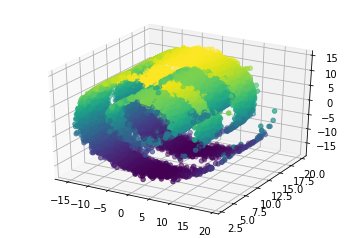

In [3]:
f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 2])
plt.show()

In [9]:
def whiten(x):
    x_meanfree = (x - np.mean(x, axis=0))
    C = (1 / (x.shape[0]-1)) * x_meanfree.T @ x_meanfree

    eigenvalues, W  = np.linalg.eigh(C)
    sig_inv = np.diag(1./np.sqrt(np.abs(eigenvalues) + 1e-6))
    C_sqrt_inv = W @ sig_inv @ W.T

    whitened = x_meanfree @ C_sqrt_inv
    return whitened

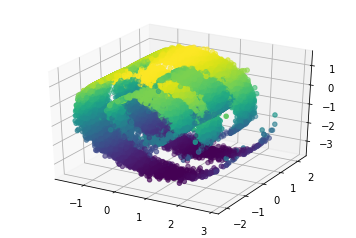

In [10]:
f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.scatter(*(whiten(data).T), c=whiten(data)[:,2])
plt.show()

Kullback-Leibler divergence $D_{\text{KL}}(P \| Q) := -\sum_i P(i)\log \frac{Q(i)}{P(i)} = \sum_i P(i)\log \frac{P(i)}{Q(i)}$.

Latent loss $D_{\text{KL}}(P \| \mathcal{N}(0,1) ) = D_\text{KL}(\mathcal{N}(\mu_\text{latent}, \sigma_\text{latent}) \| \mathcal{N}(0,1))$.

In [61]:
class TVAE(object):
    
    def __init__(self, enc_units, dec_units, ndim=3, latent_dim=2, activation=tf.nn.leaky_relu):
        self.tf_is_traing_pl = tf.placeholder_with_default(True, shape=())
        self.features = tf.placeholder(tf.float32, shape=[None, ndim])
        self.timelagged_features = tf.placeholder(tf.float32, shape=[None, ndim])
        self.latent_dim = latent_dim
        x = tf.layers.dense(self.features, units=enc_units[0], activation=activation)
        x = tf.layers.dropout(x, rate=.5, training=self.tf_is_traing_pl)
        for units in enc_units[1:]:
            x = tf.layers.dense(x, units=units, activation=activation)
            x = tf.layers.dropout(x, rate=.5, training=self.tf_is_traing_pl)
        latent_mean = tf.layers.dense(x, units=latent_dim, activation=None)
        latent_log_std_sq = tf.layers.dense(x, units=latent_dim, activation=None)
        
        samples = tf.random_normal((tf.shape(self.features)[0], latent_dim), mean=0., stddev=1., dtype=tf.float32)
        self.z = latent_mean + tf.sqrt(tf.exp(latent_log_std_sq)) * samples
        
        x = tf.layers.dense(self.z, units=dec_units[0], activation=activation)
        x = tf.layers.dropout(x, rate=.5, training=self.tf_is_traing_pl)
        for units in dec_units[1:]:
            x = tf.layers.dense(x, units=units, activation=activation)
            x = tf.layers.dropout(x, rate=.5, training=self.tf_is_traing_pl)
        self.decoded = tf.layers.dense(x, units=ndim, activation=None)
        
        reconstruction_loss = .5*tf.reduce_sum(tf.pow(self.decoded - self.timelagged_features, 2.0))
        self.reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        latent_loss = -.5 * tf.reduce_sum(1 + latent_log_std_sq - tf.sent_mean = tf.layers.dense(x, units=latent_dim, activation=None)
        latent_logquare(latent_mean) 
                                          - tf.exp(latent_log_std_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)
        self.loss = tf.reduce_mean(latent_loss + reconstruction_loss)
        self.train_operation = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(self.loss)
        
    def train(self, session, chunk, chunk_lagged):
        _, loss, reconstruction_loss, latent_loss = session.run(
            (self.train_operation, self.loss, self.reconstruction_loss, self.latent_loss),
            feed_dict={self.features: chunk, self.timelagged_features: chunk_lagged, self.tf_is_traing_pl: True}
        )
        return loss, reconstruction_loss, latent_loss
    
    def predict(self, session, batch):
        return session.run(self.decoded, 
                           feed_dict={self.features: batch, 
                                      self.tf_is_traing_pl: False})
    
    def decode(self, session, z):
        return session.run(self.decoded, 
                           feed_dict={self.z: z, self.tf_is_traing_pl: False})
    
    def encode(self, session, batch):
        return session.run(self.z, feed_dict={self.features: batch, self.tf_is_traing_pl: False})
    
    def generate(self, session, n=1, hidden=None):
        if hidden is None:
            hidden = session.run(tf.random_normal([n, self.latent_dim]))
        return session.run(self.decoded, 
                           feed_dict={self.z: hidden})

In [46]:
batch_size = 500
n_epochs = 500
lag=1

X = whiten(data[:-lag])
Y = whiten(data[lag:])

all_losses = []
all_reconstruction_losses = []
all_latent_losses = []

tvae = TVAE([300,150], [150,300], ndim=3, latent_dim=1, activation=tf.nn.leaky_relu)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=20)

    for epoch in range(n_epochs):
        losses = []
        reconstruction_losses = []
        latent_losses = []
        for ix in range(len(X) // batch_size):
            batch = X[ix*batch_size : min((ix+1)*batch_size, len(X))]
            batch_lagged = Y[ix*batch_size : min((ix+1)*batch_size, len(Y))]
            if len(batch) == len(batch_lagged):
                out = tvae.train(sess, batch, batch_lagged)
                losses.append(out[0])
                reconstruction_losses.append(out[1])
                latent_losses.append(out[2])
        if epoch % 1 == 0:
            print("epoch {}: loss {}".format(epoch, np.mean(losses)))
        if (epoch+1) % 100 == 0:
            save_path = saver.save(sess, "/tmp/tvae/model-{}.ckpt".format(epoch+1))
            print("Model saved in path: {}".format(save_path))
        all_losses.append(np.mean(losses))
        all_reconstruction_losses.append(np.mean(reconstruction_losses))
        all_latent_losses.append(np.mean(latent_losses))

epoch 0: loss 687.8828735351562
epoch 1: loss 605.9619140625
epoch 2: loss 595.3333740234375
epoch 3: loss 589.75146484375
epoch 4: loss 585.3883666992188
epoch 5: loss 582.4029541015625
epoch 6: loss 579.873291015625
epoch 7: loss 577.5599365234375
epoch 8: loss 576.3886108398438
epoch 9: loss 574.9777221679688
epoch 10: loss 573.5778198242188
epoch 11: loss 572.1290283203125
epoch 12: loss 569.3898315429688
epoch 13: loss 565.9378662109375
epoch 14: loss 562.0911865234375
epoch 15: loss 557.2781372070312
epoch 16: loss 551.904296875
epoch 17: loss 546.4976196289062
epoch 18: loss 542.424560546875
epoch 19: loss 538.6512451171875
epoch 20: loss 536.3310546875
epoch 21: loss 534.17041015625
epoch 22: loss 532.127685546875
epoch 23: loss 530.3887329101562
epoch 24: loss 529.0391845703125
epoch 25: loss 527.3832397460938
epoch 26: loss 526.4623413085938
epoch 27: loss 524.641845703125
epoch 28: loss 524.1234130859375
epoch 29: loss 523.3616333007812
epoch 30: loss 522.3644409179688
epoch

epoch 244: loss 505.4247741699219
epoch 245: loss 506.43280029296875
epoch 246: loss 505.864990234375
epoch 247: loss 506.14556884765625
epoch 248: loss 505.6923828125
epoch 249: loss 505.9632568359375
epoch 250: loss 505.7466125488281
epoch 251: loss 505.6476135253906
epoch 252: loss 505.9628601074219
epoch 253: loss 505.4286804199219
epoch 254: loss 506.2723693847656
epoch 255: loss 505.61590576171875
epoch 256: loss 505.5340881347656
epoch 257: loss 506.01312255859375
epoch 258: loss 505.45257568359375
epoch 259: loss 506.0223693847656
epoch 260: loss 505.7671813964844
epoch 261: loss 505.9436340332031
epoch 262: loss 505.4208068847656
epoch 263: loss 505.46844482421875
epoch 264: loss 505.4761047363281
epoch 265: loss 505.4852294921875
epoch 266: loss 505.3676452636719
epoch 267: loss 505.5947570800781
epoch 268: loss 506.05181884765625
epoch 269: loss 505.58331298828125
epoch 270: loss 505.60858154296875
epoch 271: loss 505.74420166015625
epoch 272: loss 505.6840515136719
epoch 27

epoch 483: loss 505.1014404296875
epoch 484: loss 504.87646484375
epoch 485: loss 505.1878967285156
epoch 486: loss 505.1621398925781
epoch 487: loss 504.6059265136719
epoch 488: loss 505.06854248046875
epoch 489: loss 505.2481689453125
epoch 490: loss 504.8987121582031
epoch 491: loss 505.19677734375
epoch 492: loss 504.6524963378906
epoch 493: loss 504.5567626953125
epoch 494: loss 505.0878601074219
epoch 495: loss 504.868408203125
epoch 496: loss 504.8574523925781
epoch 497: loss 504.7869567871094
epoch 498: loss 504.9670104980469
epoch 499: loss 504.9549255371094
Model saved in path: /tmp/tvae/model-500.ckpt


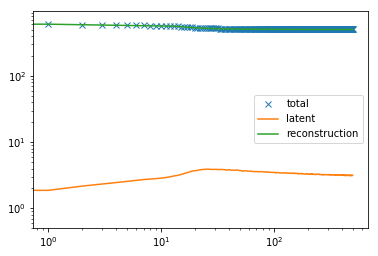

In [47]:
plt.loglog(all_losses, 'x', label='total')
plt.loglog(all_latent_losses, label='latent')
plt.loglog(all_reconstruction_losses, label='reconstruction')
plt.legend()

In [48]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "/tmp/tvae/model-500.ckpt")
    latent = tvae.encode(sess, whiten(data))

INFO:tensorflow:Restoring parameters from /tmp/tvae/model-500.ckpt


In [49]:
cc = KMeans(n_clusters=4).fit(latent).cluster_centers_

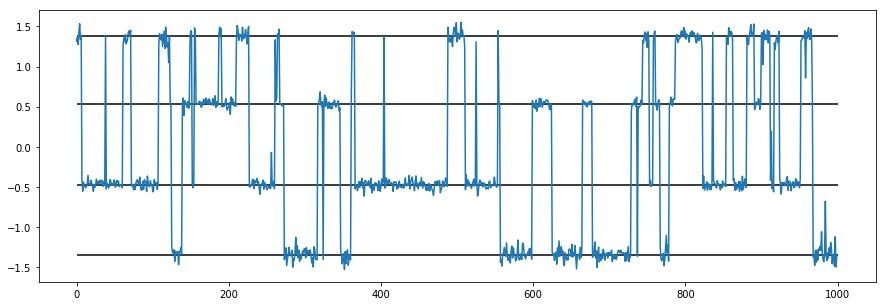

In [50]:
f, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(latent[:1000])
ax.hlines(cc, xmin=0, xmax=1000)

In [51]:
cc

array([[-1.3434253 ],
       [ 0.53731245],
       [ 1.3768935 ],
       [-0.47274953]], dtype=float32)

In [52]:
guess = np.abs(latent[:, 0, None] - cc.squeeze()[None, :]).argmin(axis=1) #np.array([-1.5, -.5, .5, 1.5])
np.max([np.sum(np.array(p)[dtraj] == guess) for p in itertools.permutations([1,2,3,0])]) * 100. / len(dtraj)

99.821

In [39]:
class TAE(object):
    
    def __init__(self, enc_units, dec_units, ndim=3, latent_dim=2, activation=tf.nn.leaky_relu, dropout=.3):
        self.tf_is_traing_pl = tf.placeholder_with_default(True, shape=())
        self.features = tf.placeholder(tf.float32, shape=[None, ndim])
        self.timelagged_features = tf.placeholder(tf.float32, shape=[None, ndim])
        x = tf.layers.batch_normalization(self.features)
        x = tf.layers.dense(x, units=enc_units[0], activation=activation)
        x = tf.layers.dropout(x, rate=dropout, training=self.tf_is_traing_pl)
        for units in enc_units[1:]:
            x = tf.layers.dense(x, units=units, activation=activation)
            x = tf.layers.dropout(x, rate=dropout, training=self.tf_is_traing_pl)
        
        self.z = tf.layers.dense(x, latent_dim, activation=None)
        
        x = tf.layers.dense(self.z, units=dec_units[0], activation=activation)
        x = tf.layers.dropout(x, rate=dropout, training=self.tf_is_traing_pl)
        for units in dec_units[1:]:
            x = tf.layers.dense(x, units=units, activation=activation)
            x = tf.layers.dropout(x, rate=dropout, training=self.tf_is_traing_pl)
        self.decoded = tf.layers.dense(x, units=ndim, activation=None)
        
        self.loss = tf.losses.mean_squared_error(self.timelagged_features, self.decoded)
        self.train_operation = tf.train.AdamOptimizer(learning_rate=5e-5).minimize(self.loss)
        
    def train(self, session, X, Y):
        self.training = True
        _, loss, = session.run(
            (self.train_operation, self.loss),
            feed_dict={self.features: X, self.timelagged_features: Y, self.tf_is_traing_pl: True}
        )
        self.training = False
        return loss
    
    def predict(self, session, batch):
        return session.run(self.decoded, feed_dict={self.features: batch, self.tf_is_traing_pl: False})
    
    def decode(self, session, z):
        return session.run(self.decoded, feed_dict={self.z: z, self.tf_is_traing_pl: False})
    
    def encode(self, session, batch):
        return session.run(self.z, feed_dict={self.features: batch, self.tf_is_traing_pl: False})

In [40]:
batch_size = 500
n_epochs = 2000
lag=1

all_losses = []
all_reconstruction_losses = []
all_latent_losses = []

X = whiten(data[:-lag])
Y = whiten(data[lag:])

tae = TAE([200,100], [100,200], ndim=3, latent_dim=1, activation=tf.nn.leaky_relu, dropout=.5)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=20)

    for epoch in range(n_epochs):
        losses = []
        for ix in range(len(data) // batch_size):
            batch = X[ix*batch_size : min((ix+1)*batch_size, len(X))]
            batch_lagged = Y[ix*batch_size : min((ix+1)*batch_size, len(Y))]
            if len(batch) == len(batch_lagged):
                out = tae.train(sess, batch, batch_lagged)
                losses.append(out)
            
        if epoch % 1 == 0:
            print("epoch {}: loss {}".format(epoch, np.mean(losses)))
        if (epoch+1) % 100 == 0:
            save_path = saver.save(sess, "/tmp/tae/model-{}.ckpt".format(epoch+1))
            print("Model saved in path: {}".format(save_path))
        all_losses.append(np.mean(losses))

epoch 0: loss 0.9104360938072205
epoch 1: loss 0.8112969994544983
epoch 2: loss 0.8029745221138
epoch 3: loss 0.7963126301765442
epoch 4: loss 0.7910808324813843
epoch 5: loss 0.786464512348175
epoch 6: loss 0.783261239528656
epoch 7: loss 0.7797180414199829
epoch 8: loss 0.777443528175354
epoch 9: loss 0.7756873369216919
epoch 10: loss 0.773606538772583
epoch 11: loss 0.7725178599357605
epoch 12: loss 0.7706075310707092
epoch 13: loss 0.7690097093582153
epoch 14: loss 0.7678083181381226
epoch 15: loss 0.7665800452232361
epoch 16: loss 0.7651917934417725
epoch 17: loss 0.764069139957428
epoch 18: loss 0.7631343007087708
epoch 19: loss 0.7618544101715088
epoch 20: loss 0.7602236866950989
epoch 21: loss 0.7583329677581787
epoch 22: loss 0.7555481791496277
epoch 23: loss 0.7533700466156006
epoch 24: loss 0.7500727772712708
epoch 25: loss 0.7470364570617676
epoch 26: loss 0.7447736859321594
epoch 27: loss 0.7417082190513611
epoch 28: loss 0.7389818429946899
epoch 29: loss 0.736906826496124

epoch 236: loss 0.6774218678474426
epoch 237: loss 0.6781710982322693
epoch 238: loss 0.6767840385437012
epoch 239: loss 0.6775171160697937
epoch 240: loss 0.6770671010017395
epoch 241: loss 0.6774451732635498
epoch 242: loss 0.6773176789283752
epoch 243: loss 0.6774716973304749
epoch 244: loss 0.6764898896217346
epoch 245: loss 0.6765139698982239
epoch 246: loss 0.6770806908607483
epoch 247: loss 0.6770007610321045
epoch 248: loss 0.6768697500228882
epoch 249: loss 0.6769711375236511
epoch 250: loss 0.6767780780792236
epoch 251: loss 0.6763278245925903
epoch 252: loss 0.6763633489608765
epoch 253: loss 0.6766670942306519
epoch 254: loss 0.6765890717506409
epoch 255: loss 0.6764552593231201
epoch 256: loss 0.6763954162597656
epoch 257: loss 0.6769282817840576
epoch 258: loss 0.6769515872001648
epoch 259: loss 0.6768167018890381
epoch 260: loss 0.6766295433044434
epoch 261: loss 0.6766621470451355
epoch 262: loss 0.6764538288116455
epoch 263: loss 0.6764506697654724
epoch 264: loss 0.67

epoch 469: loss 0.6744866967201233
epoch 470: loss 0.6741682291030884
epoch 471: loss 0.6737313866615295
epoch 472: loss 0.6740481853485107
epoch 473: loss 0.6744347214698792
epoch 474: loss 0.6746816039085388
epoch 475: loss 0.6742215156555176
epoch 476: loss 0.6743661761283875
epoch 477: loss 0.6741702556610107
epoch 478: loss 0.6743791103363037
epoch 479: loss 0.6738229393959045
epoch 480: loss 0.6739256381988525
epoch 481: loss 0.6736177206039429
epoch 482: loss 0.6746190786361694
epoch 483: loss 0.6744406819343567
epoch 484: loss 0.6747109889984131
epoch 485: loss 0.6736243367195129
epoch 486: loss 0.6747256517410278
epoch 487: loss 0.6737371683120728
epoch 488: loss 0.6739087104797363
epoch 489: loss 0.6749294996261597
epoch 490: loss 0.6740160584449768
epoch 491: loss 0.6742079257965088
epoch 492: loss 0.6744851469993591
epoch 493: loss 0.6740605235099792
epoch 494: loss 0.6739277839660645
epoch 495: loss 0.6741113066673279
epoch 496: loss 0.6741657257080078
epoch 497: loss 0.67

epoch 700: loss 0.6741482019424438
epoch 701: loss 0.6733213663101196
epoch 702: loss 0.6731153726577759
epoch 703: loss 0.6733464598655701
epoch 704: loss 0.6740761399269104
epoch 705: loss 0.6726905703544617
epoch 706: loss 0.6736253499984741
epoch 707: loss 0.6733397841453552
epoch 708: loss 0.6734081506729126
epoch 709: loss 0.6736708283424377
epoch 710: loss 0.6735050082206726
epoch 711: loss 0.6729381084442139
epoch 712: loss 0.6726815700531006
epoch 713: loss 0.6740703582763672
epoch 714: loss 0.6735527515411377
epoch 715: loss 0.6732366681098938
epoch 716: loss 0.673554539680481
epoch 717: loss 0.6726167798042297
epoch 718: loss 0.6736459136009216
epoch 719: loss 0.6738845705986023
epoch 720: loss 0.6741809248924255
epoch 721: loss 0.6734793186187744
epoch 722: loss 0.673180341720581
epoch 723: loss 0.6731930375099182
epoch 724: loss 0.6730924248695374
epoch 725: loss 0.6736428737640381
epoch 726: loss 0.6738051772117615
epoch 727: loss 0.6733910441398621
epoch 728: loss 0.6734

epoch 932: loss 0.6727728247642517
epoch 933: loss 0.6731784343719482
epoch 934: loss 0.6732812523841858
epoch 935: loss 0.673258364200592
epoch 936: loss 0.6728898882865906
epoch 937: loss 0.6729792952537537
epoch 938: loss 0.6732482314109802
epoch 939: loss 0.6732046604156494
epoch 940: loss 0.6732734441757202
epoch 941: loss 0.6729844808578491
epoch 942: loss 0.6732685565948486
epoch 943: loss 0.6732763648033142
epoch 944: loss 0.6729623675346375
epoch 945: loss 0.6734870672225952
epoch 946: loss 0.6727954149246216
epoch 947: loss 0.6729388236999512
epoch 948: loss 0.6730902791023254
epoch 949: loss 0.6731362342834473
epoch 950: loss 0.6730968356132507
epoch 951: loss 0.6735048890113831
epoch 952: loss 0.6730878949165344
epoch 953: loss 0.6730183362960815
epoch 954: loss 0.672882080078125
epoch 955: loss 0.6737123727798462
epoch 956: loss 0.6729381084442139
epoch 957: loss 0.673337996006012
epoch 958: loss 0.6727234721183777
epoch 959: loss 0.6727184057235718
epoch 960: loss 0.67158

epoch 1160: loss 0.6725361347198486
epoch 1161: loss 0.6728050708770752
epoch 1162: loss 0.6729065179824829
epoch 1163: loss 0.6720839738845825
epoch 1164: loss 0.6725718975067139
epoch 1165: loss 0.6727864742279053
epoch 1166: loss 0.6727910041809082
epoch 1167: loss 0.6727021932601929
epoch 1168: loss 0.6726877093315125
epoch 1169: loss 0.6732773780822754
epoch 1170: loss 0.6727450489997864
epoch 1171: loss 0.6726676821708679
epoch 1172: loss 0.6722268462181091
epoch 1173: loss 0.6728207468986511
epoch 1174: loss 0.6732866764068604
epoch 1175: loss 0.6731836199760437
epoch 1176: loss 0.6733180284500122
epoch 1177: loss 0.6728987693786621
epoch 1178: loss 0.6728733777999878
epoch 1179: loss 0.673092782497406
epoch 1180: loss 0.6724487543106079
epoch 1181: loss 0.6731773614883423
epoch 1182: loss 0.6731141805648804
epoch 1183: loss 0.672442615032196
epoch 1184: loss 0.6727156639099121
epoch 1185: loss 0.672698974609375
epoch 1186: loss 0.6732349395751953
epoch 1187: loss 0.673363327980

epoch 1386: loss 0.6723374724388123
epoch 1387: loss 0.6723397970199585
epoch 1388: loss 0.6721803545951843
epoch 1389: loss 0.6728894114494324
epoch 1390: loss 0.672433614730835
epoch 1391: loss 0.67271888256073
epoch 1392: loss 0.6721570491790771
epoch 1393: loss 0.6730758547782898
epoch 1394: loss 0.6721401214599609
epoch 1395: loss 0.6729494333267212
epoch 1396: loss 0.673088550567627
epoch 1397: loss 0.6725319027900696
epoch 1398: loss 0.6727817058563232
epoch 1399: loss 0.6726182699203491
Model saved in path: /tmp/tae/model-1400.ckpt
epoch 1400: loss 0.6728298664093018
epoch 1401: loss 0.6723158359527588
epoch 1402: loss 0.6728971004486084
epoch 1403: loss 0.6727247834205627
epoch 1404: loss 0.672960638999939
epoch 1405: loss 0.6726492047309875
epoch 1406: loss 0.672417402267456
epoch 1407: loss 0.6731220483779907
epoch 1408: loss 0.6726934313774109
epoch 1409: loss 0.6726565361022949
epoch 1410: loss 0.6729872226715088
epoch 1411: loss 0.6730872988700867
epoch 1412: loss 0.67261

epoch 1611: loss 0.6725804209709167
epoch 1612: loss 0.6721041202545166
epoch 1613: loss 0.6725784540176392
epoch 1614: loss 0.6723521947860718
epoch 1615: loss 0.6725758910179138
epoch 1616: loss 0.6722674369812012
epoch 1617: loss 0.6728875041007996
epoch 1618: loss 0.6720260381698608
epoch 1619: loss 0.672331690788269
epoch 1620: loss 0.6727758049964905
epoch 1621: loss 0.6722443103790283
epoch 1622: loss 0.6721463799476624
epoch 1623: loss 0.6721338033676147
epoch 1624: loss 0.673000693321228
epoch 1625: loss 0.6729307770729065
epoch 1626: loss 0.6727247834205627
epoch 1627: loss 0.6715121269226074
epoch 1628: loss 0.6721314787864685
epoch 1629: loss 0.6718232035636902
epoch 1630: loss 0.6716673374176025
epoch 1631: loss 0.672505795955658
epoch 1632: loss 0.6719672679901123
epoch 1633: loss 0.6724276542663574
epoch 1634: loss 0.6725924611091614
epoch 1635: loss 0.6727532148361206
epoch 1636: loss 0.6725775003433228
epoch 1637: loss 0.6726222038269043
epoch 1638: loss 0.671967744827

epoch 1837: loss 0.6731785535812378
epoch 1838: loss 0.6723437309265137
epoch 1839: loss 0.672537624835968
epoch 1840: loss 0.6727632880210876
epoch 1841: loss 0.6729667782783508
epoch 1842: loss 0.6725804209709167
epoch 1843: loss 0.671703577041626
epoch 1844: loss 0.6726528406143188
epoch 1845: loss 0.6720578074455261
epoch 1846: loss 0.6726741194725037
epoch 1847: loss 0.6727238297462463
epoch 1848: loss 0.6727837920188904
epoch 1849: loss 0.6721938848495483
epoch 1850: loss 0.6723714470863342
epoch 1851: loss 0.6729084849357605
epoch 1852: loss 0.6722999811172485
epoch 1853: loss 0.672228991985321
epoch 1854: loss 0.6731494069099426
epoch 1855: loss 0.6722155213356018
epoch 1856: loss 0.6727429032325745
epoch 1857: loss 0.6722773909568787
epoch 1858: loss 0.6728050708770752
epoch 1859: loss 0.6725430488586426
epoch 1860: loss 0.6721037030220032
epoch 1861: loss 0.6728267073631287
epoch 1862: loss 0.6732786297798157
epoch 1863: loss 0.672016978263855
epoch 1864: loss 0.6720271110534

In [42]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "/tmp/tae/model-2000.ckpt")
    latent = tae.encode(sess, whiten(data))  # whiten(data)

INFO:tensorflow:Restoring parameters from /tmp/tae/model-2000.ckpt


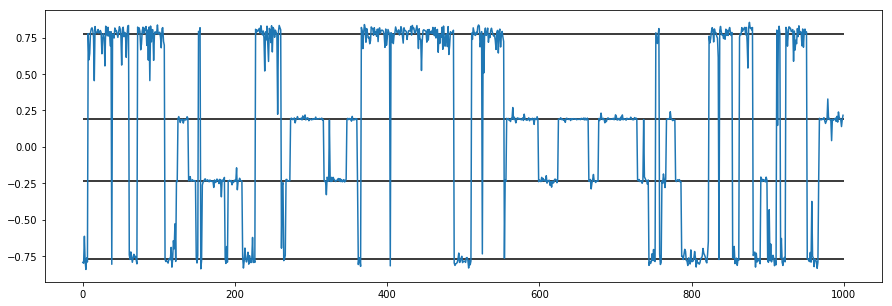

In [43]:
cc = KMeans(n_clusters=4).fit(latent).cluster_centers_
# cc = [-0.05, .07, .2, -.2]
f, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(latent[:1000])
ax.hlines(cc, xmin=0, xmax=1000)
plt.show()

In [44]:
guess = np.abs(latent[:, 0, None] - np.array(cc).squeeze()[None, :]).argmin(axis=1)
perms = [np.sum(np.array(p)[dtraj] == guess) for p in itertools.permutations([1,2,3,0])]
percent = np.max(perms) * 100. / len(dtraj)
print("{:.4f}%".format(percent))

99.5740%
